In [15]:
#Imports
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from itertools import zip_longest
from torchsummaryX import summary as summaryx
import matplotlib.pyplot as plt

In [2]:
#Import data
toxic_train = pd.read_csv('data/train.csv')
toxic_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [3]:
#Clean data
def CleanAndSplit(toxic_train):
    toxic_train = toxic_train.drop(['id'], axis=1)
    toxic_train = toxic_train.to_numpy()
    toxic_data, toxic_classes = toxic_train[:,0].astype('str'), toxic_train[:,1:]
    return toxic_data, toxic_classes

toxic_data, toxic_classes = CleanAndSplit(toxic_train)

In [4]:
#Vectorize data
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data):
    for text in data:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(toxic_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
pipeline = lambda x: vocab(tokenizer(x))


In [5]:
class CustomDataset(Dataset):
    def __init__(self, data, classes):
        self.data = data
        self.classes = classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.classes[idx]
    
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _text, _label in batch:
        label_list.append(_label)
        processed_text = torch.tensor(pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.tensor(list(zip_longest(*text_list, fillvalue=0))).T
    return  text_list, label_list, offsets

In [9]:
class Model(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embed_layer =  nn.EmbeddingBag(vocab_size+1, embed_dim)
        self.lstm = nn.LSTM(embed_dim, 20, bidirectional=True) # nn.Tanh()
        self.linear_1 = nn.Linear(40, 32) # nn.ReLU()
        self.linear_2 = nn.Linear(32, 16) # nn.ReLU()
        self.linear_3 = nn.Linear(16, 6) # nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embed_layer(x)
        out, _ = self.lstm(embedded)
        out = self.tanh(out)
        out = self.relu(self.linear_1(out))
        out = self.relu(self.linear_2(out))
        out = self.sigmoid(self.linear_3(out))
        return out


In [10]:
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64
model = Model(VOCAB_SIZE, EMBED_DIM)
dataset = CustomDataset(toxic_data, toxic_classes)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
epochs = 5

In [14]:
def train(model, epochs):
    model.train()
    total_acc, total_loss, total_count = 0, 0, 0
    accs, losses = [], []


    for epoch in range(epochs):
        epoch_time = time.time()

        for idx, (text, label, offsets) in enumerate(dataloader):
            acc = 0
            optimizer.zero_grad()
            if idx==0 and epoch==0:
                print(summaryx(model, text))
            predicted_label = model(text)
            loss = criterion(predicted_label.type(torch.FloatTensor), label.type(torch.FloatTensor))
            total_loss += loss
            loss.backward()
            optimizer.step()
            for i, p in enumerate(predicted_label):
                if torch.all((p>0.5).float().eq(label[i])):
                    acc+=1
            total_acc += acc
            total_count += label.size(0)
            accs.append(acc/label.size(0))
            losses.append(loss)
        
        elapsed_time = time.time() - epoch_time
        print(
            "| epoch {:3d} | {:8.3f} seconds elapsed "
            "| accuracy {:8.3f} | loss {:8.3f}".format(
                epoch, elapsed_time, total_acc / total_count, total_loss / total_count
            )
        )
        total_acc, total_loss, total_count = 0, 0, 0
    
    return model, accs, losses

model, accs, losses = train(model, epochs)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


               Kernel Shape Output Shape      Params   Mult-Adds
Layer                                                           
0_embed_layer  [64, 243146]     [64, 64]  15.561344M  15.561344M
1_lstm                    -     [64, 40]      13.76k      13.44k
2_tanh                    -     [64, 40]           -           -
3_linear_1         [40, 32]     [64, 32]      1.312k       1.28k
4_relu                    -     [64, 32]           -           -
5_linear_2         [32, 16]     [64, 16]       528.0       512.0
6_relu                    -     [64, 16]           -           -
7_linear_3          [16, 6]      [64, 6]       102.0        96.0
8_sigmoid                 -      [64, 6]           -           -
----------------------------------------------------------------
                          Totals
Total params          15.577046M
Trainable params      15.577046M
Non-trainable params         0.0
Mult-Adds             15.576672M
               Kernel Shape Output Shape      Params   

In [ ]:
#Save progress
torch.save(model,'saved_model.pt')
torch.save(vocab, 'saved_vocab.pth')
losses= [ loss.detach().numpy() for loss in losses]

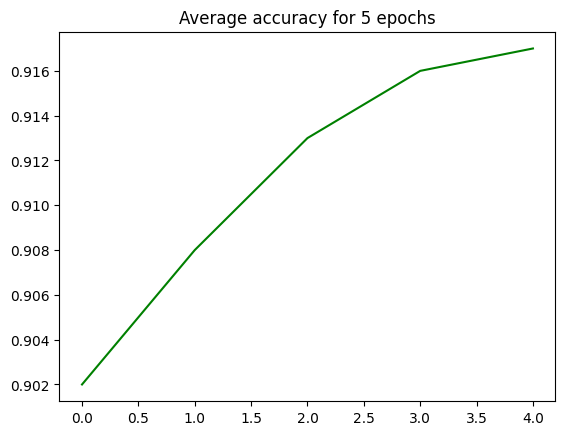

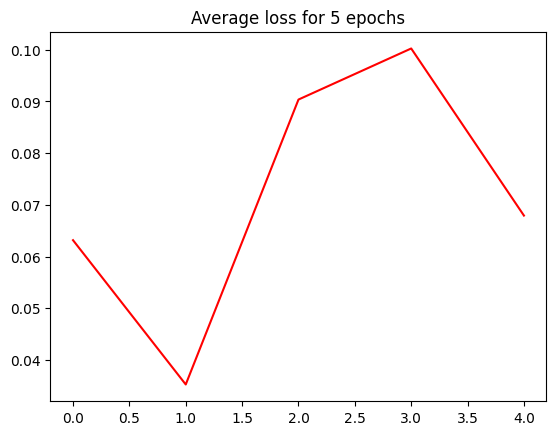

In [31]:
plt.title("Average accuracy for 5 epochs")
plt.plot([0.902,0.908,0.913,0.916,0.917], color="green")
plt.show()
plt.title("Average loss for 5 epochs")
plt.plot(losses[len(losses)-10:len(losses)-5], color="red")
plt.show()

In [ ]:
test = "how dumb can u be frl"
def getPrediction(text):
    response = []
    classes = ['Toxic','Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']
    text = pipeline(text)
    text = torch.LongTensor(text)
    text = text[None,:]
    pred = model(text)[0]
    results = (pred>0.9).nonzero()
    for r in results:
        response.append(classes[r[0].item()])
    return response, pred

getPrediction(test)
